In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import os
import spacy

from glob import glob
from typing import Callable
from typing import Dict
from typing import List
from typing import Tuple

In [2]:
nlp = spacy.load('pl_spacy_model', disable=['ner', 'parser'])

In [3]:
!wc -l ../PLArticlesScraper/PLArticlesScraper/scrapy_output/*.jsonl

    3806 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/bankier.jsonl
     789 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/bankier_moto.jsonl
    4702 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/bryla.jsonl
   12946 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/gazetakrakowska.jsonl
    5905 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/krakowwpigulce.jsonl
      93 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/mamstartup.jsonl
     356 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/naszemiasto.jsonl
   67651 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/nowiny24.jsonl
    5280 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/nowymarketing.jsonl
   25686 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/polki.jsonl
   29133 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/spidersweb.jsonl
   78389 ../PLArticlesScraper/PLArticlesScraper/scrapy_output/sport.jsonl
    3536 ../PLArticlesScraper/PLArticlesScraper/scrapy_ou

In [4]:
class FilesReader:
    def __init__(self, data_paths: str):
        self.data_paths = data_paths
        self.files = glob(data_paths + '*')
        self.files.sort()
        self._get_file_names()
        self.data = None
        
    def _get_file_names(self):
        self.file_names = [
            os.path.basename(file).split('.')[0]
            for file in self.files
        ]
        
    def read_json_lines_files(self) -> None:
        self.data = dict(zip(
            self.file_names, 
            (pd.DataFrame(self._read_json_lines_file(file)) for file in self.files),
        ))
        
    def _read_json_lines_file(self, file: str) -> list:
        list_of_lines = []
        with open(file, 'r', encoding='utf-8') as opened_file:
            for line in opened_file:
                list_of_lines.append(json.loads(line.rstrip('\n|\r')))
        return list_of_lines

In [5]:
class Filterer:
    MIN_MAX_LENGTH = (5, 100)
    
    def __init__(
        self, 
        title_lead_length_limit: Tuple[int, int]=MIN_MAX_LENGTH, 
        text_length_limit: Tuple[int, int]=MIN_MAX_LENGTH, 
        reset_index: bool=True,
    ):
        self.title_lead_length_limit = title_lead_length_limit
        self.text_length_limit = text_length_limit
        self.column_types = ['header', 'text']
        self.default_header_columns = ['title', 'lead']
        self.default_text_columns = ['text']
        self.reset_index=True
        self.set_conditions(title_lead_length=title_lead_length_limit, text_length=text_length_limit)
        
    def get_default_columns(self, skip_title: bool=True) -> Dict[str, List[str]]:
        header_columns = self.default_header_columns
        if skip_title:
            header_columns = [header for header in self.default_header_columns if header != 'title']
        return dict(zip(self.column_types, (header_columns, self.default_text_columns)))
    
    def get_default_conditions(self) -> Dict[str, Callable]:
        return dict(zip(self.column_types, self.conditions)) 
    
    def set_conditions(
        self, 
        title_lead_length: Tuple[int, int]=MIN_MAX_LENGTH, 
        text_length: Tuple[int, int]=MIN_MAX_LENGTH,
    ) -> None:
        self.conditions = [
            self.set_condition(title_lead_length), self.set_condition(text_length)
        ]
        
    def set_condition(self, length: Tuple[int, int]) -> Callable:
        return lambda x: max(length[0], 1) <= len(" ".join(x).strip().split()) <= length[1] \
            if isinstance(x, list) else max(length[0], 1) <= len(x.strip().split()) <= length[1]
        
    def filter_site_data(
        self, 
        data: pd.DataFrame, 
        columns_names: Dict[str, List[str]]=None, 
        conditions: Dict[str, Callable]=None,
        skip_title: bool=True,
    ) -> pd.DataFrame:
        if not columns_names:
            columns_names = self.get_default_columns()
        if not conditions:
            conditions = self.get_default_conditions()

        for column_type, col_names in columns_names.items():
            column_condition = conditions[column_type]
            for col_name in col_names:
                data = data[data[col_name].map(column_condition)]
        if self.reset_index:
            return data.reset_index(drop=True)
        return data

In [56]:
samples = [
    " sa as as a a dsas",
    ["sad", "sad", "dsa", "as a sadad asdsad dsa"],
    ["asodi asdop saop sa op aso ap dopa spas. a das da ad asdad"],
]

In [186]:
class UtilsCounter:
    def __init__(self):
        pass
    
    def calculate_words(self, text, return_words=False):
        words = self.strip_text(words)
        words = self.tokenize_text(words)
        number_of_words = len(words)
        if return_words:
            return number_of_words, words
        return number_of_words
    
    def remove_html_elements(self, text, elements_to_preserve=None):
        pass
    
    def strip_text(self, text):
        if text:
            text = " ".join(text).strip().split() if isinstance(text, list) else "".join(text).strip().split()
            return text
        return ""
    
    def tokenize_text(self, text):
        text = re.sub("(\\t|\\r|\\n)", ' ', str(text)) # tab or newline chars
        text = re.sub("(__+|-+|~+|\+\++|\.\.+|\-\s+|\:+)", ' ', str(text))
        text = re.sub("\s+", ' ', str(text)) # remove whitespaces

        text = re.sub(r"[<>()|&©ø\[\]\'\"\`,;~*]", '', str(text))
        text = re.sub(r"[?!]", '.', str(text))
        return [tok.text for tok in nlp.tokenizer(text)]

In [187]:
utilsCounter = UtilsCounter()

In [148]:
file_reader = FilesReader(data_paths='../PLArticlesScraper/PLArticlesScraper/scrapy_output/')

In [149]:
file_reader.read_json_lines_files()

In [10]:
file_reader.data['bankier'].head()

,url,title,lead,text,text_main_points
0,https://www.bankier.pl/wiadomosc/Oszustwo-SMS-...,"[""Pieniądze z Państwa konta przekazane do NBP""...",[Największy bank w Polsce bije na alarm: oszuś...,"[""Przekażcie dalej i ostrzeżcie znajomych"" - a...",[]
1,https://www.bankier.pl/wiadomosc/Zakaz-handlu-...,[Zakaz handlu zawieszony z powodu koronawirusa...,[Zawieszenie wejścia w życie wszelkich ustaw w...,[\r\nJak czytamy w stanowisku KIG przysłanym w...,[]
2,https://www.bankier.pl/wiadomosc/Czechy-zamyka...,[Czechy zamykają sklepy i restauracje],[Władze Republiki Czeskiej poinformowały w noc...,[Otwarte będą natomiast wszystkie stacje benzy...,[]
3,https://www.bankier.pl/wiadomosc/5-tematow-min...,[5 tematów mijającego tygodnia ważnych dla two...,[W mijającym tygodniu\r\nopisywaliśmy szereg t...,[W ramach cyklu „5\r\ntematów minionego tygodn...,[]
4,https://www.bankier.pl/wiadomosc/Turczynowicz-...,[Turczynowicz-Kieryłło rezygnuje funkcji szefo...,[Z uwagi na stan zdrowia nie będę pełnić już f...,"[\r\n, ""Moi Drodzy, z uwagi na stan zdrowia ni...",[]


In [150]:
for key in file_reader.data.keys():
    print(f'{key} : {len(file_reader.data[key])}')

bankier : 201
bankier_moto : 797
bankier_previous : 3806
bryla : 4702
gazetakrakowska : 12946
krakowwpigulce : 5905
mamstartup : 93
naszemiasto : 356
nowiny24 : 67651
nowymarketing : 5280
polki : 25686
spidersweb : 29133
sport : 78389
strefainwestorow : 3536
sztukaarchitektury : 3939
wirtualnemedia_biznes : 6664
wnp : 476


### Plot histograms

In [190]:
def plot_data_for_column(data, file_names, column, bins=25, max_percentile=1, x_limit=None, normalize=False):
    plt.figure(figsize=(16, 8))
    for i, file_name in enumerate(file_names):
        file_dataframe = data[file_name]
        file_dataframe = file_dataframe[file_dataframe[column].map(lambda x: len(utilsCounter.strip_text(x))) < \
            file_dataframe[column].map(lambda x: len(utilsCounter.strip_text(x))).quantile(max_percentile)
        ]
        try:
            file_dataframe.applymap(lambda x: len(utilsCounter.strip_text(x)))[column].plot.hist(
                bins=bins, title=f'Length of {column}s', label=file_name, legend=True, logy=True, 
                density=1 if normalize else None, color=plt.cm.tab20(i), alpha=0.8
            )
        except TypeError:
            continue
    plt.show()

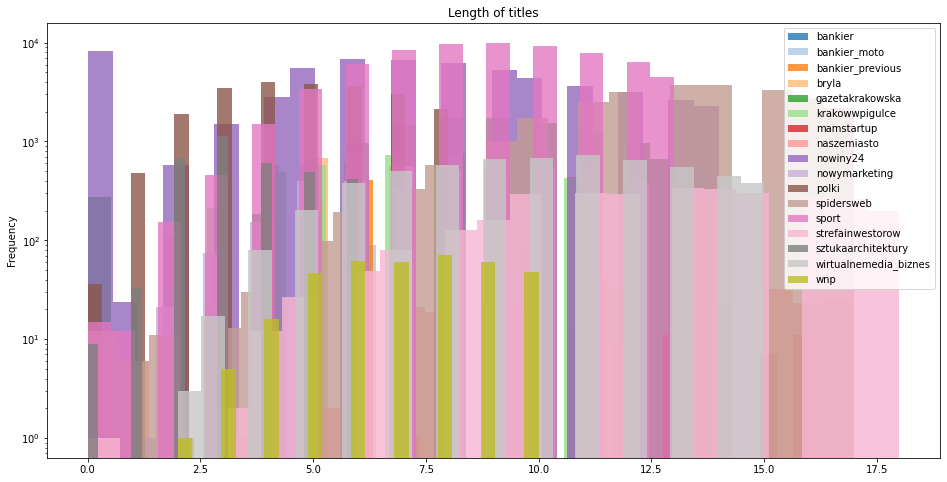

In [191]:
plot_data_for_column(file_reader.data, file_reader.file_names, column='title', max_percentile=.9)

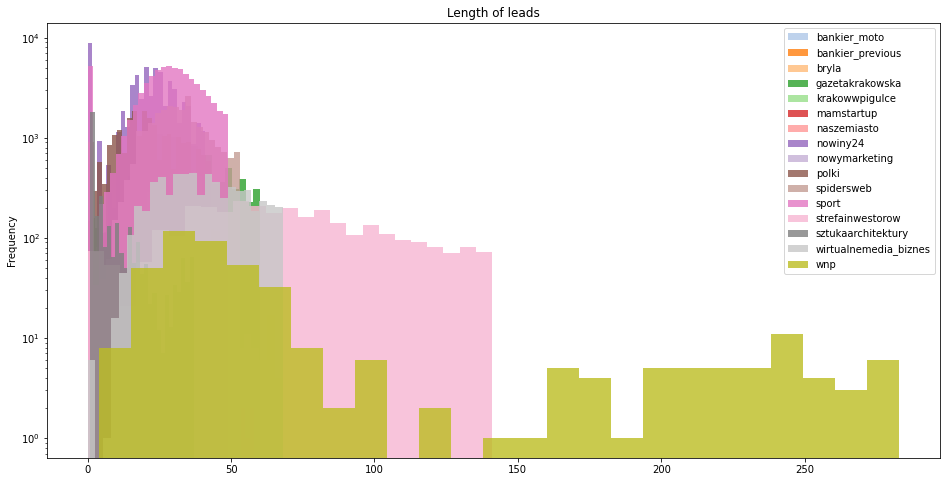

In [192]:
plot_data_for_column(file_reader.data, file_reader.file_names, column='lead', max_percentile=.9)

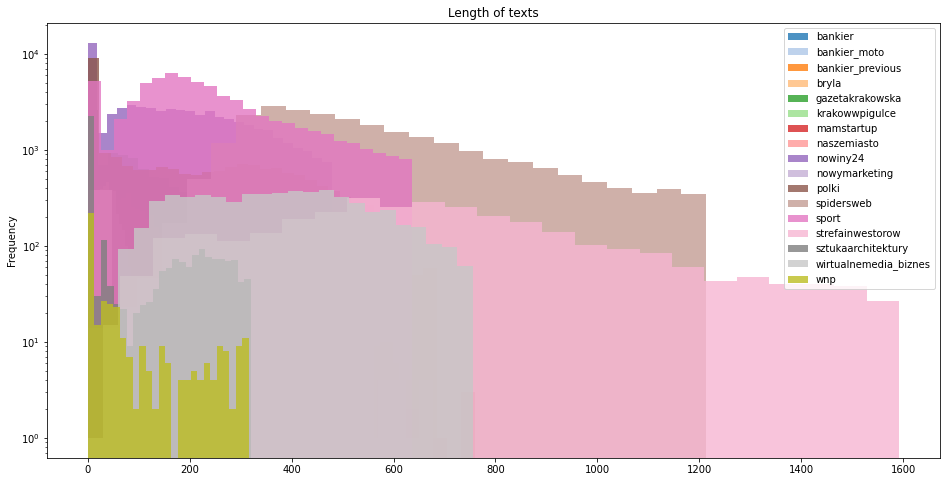

In [193]:
plot_data_for_column(file_reader.data, file_reader.file_names, column='text', max_percentile=.9)

In [196]:
def plot_data_for_column_single(data, file_names, column, bins=25, max_percentile=1, x_limit=None, normalize=False):
    for i, file_name in enumerate(file_names):
        plt.figure(figsize=(12, 5))
        file_dataframe = data[file_name]
        file_dataframe = file_dataframe[file_dataframe[column].map(lambda x: len(utilsCounter.strip_text(x))) < \
            file_dataframe[column].map(lambda x: len(utilsCounter.strip_text(x))).quantile(max_percentile)
        ]
        try:
            file_dataframe.applymap(lambda x: len(utilsCounter.strip_text(x)))[column].plot.hist(
                bins=bins, title=f'Length of {column}s', label=file_name, legend=True, logy=False, 
                density=1 if normalize else None, color=plt.cm.tab20(i), alpha=1
            )
        except TypeError:
            continue
        plt.show()

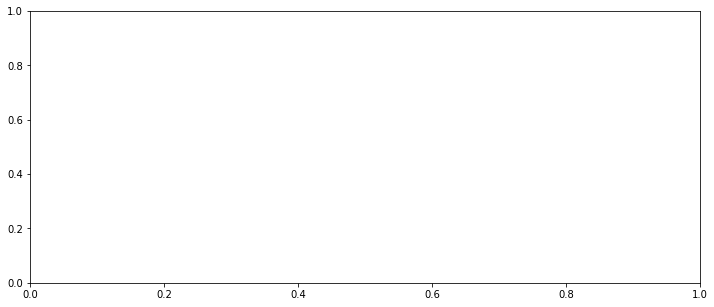

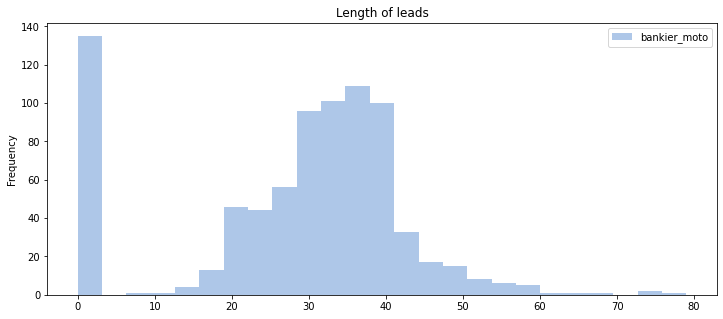

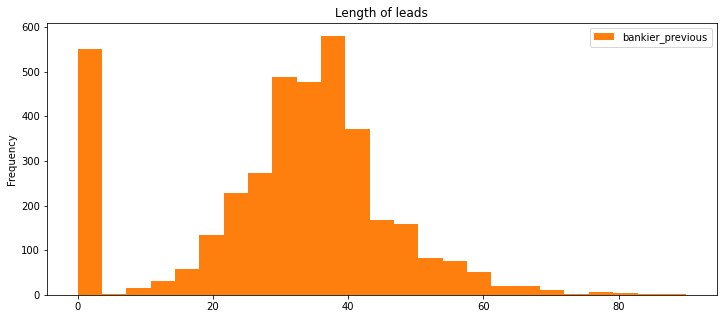

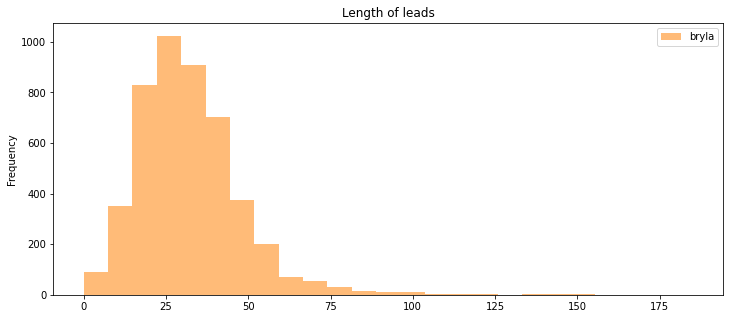

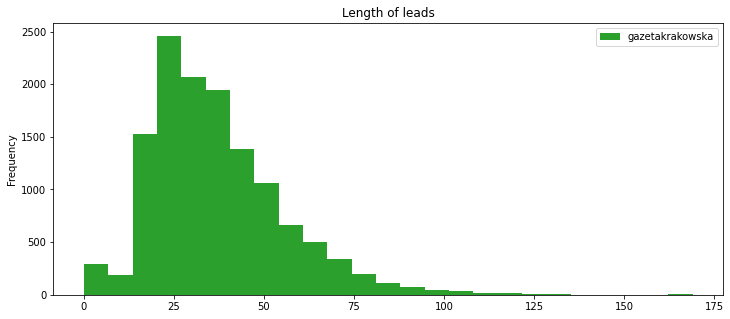

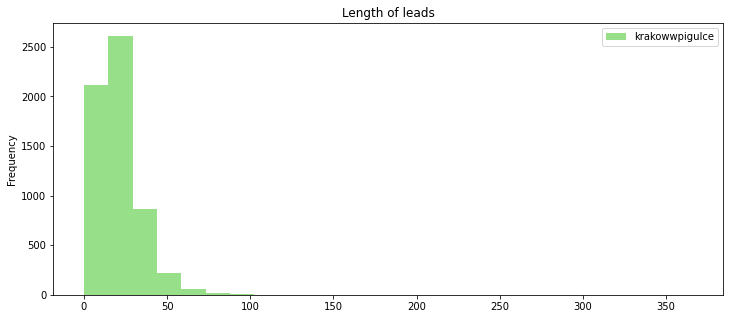

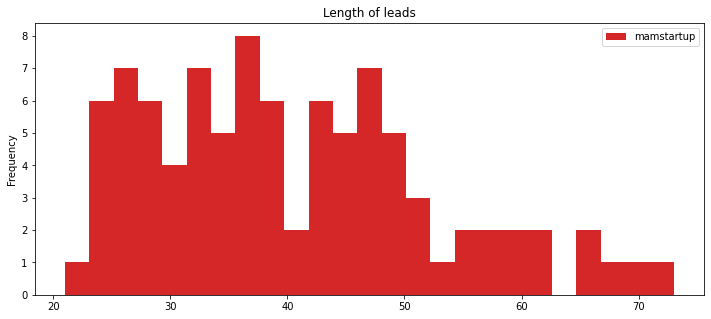

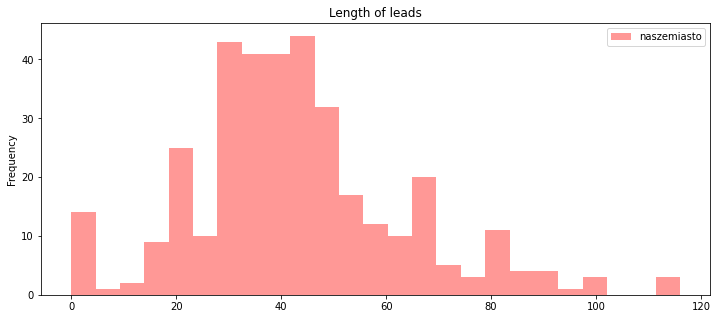

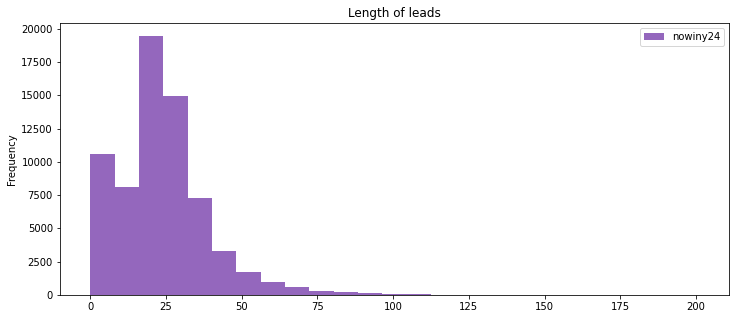

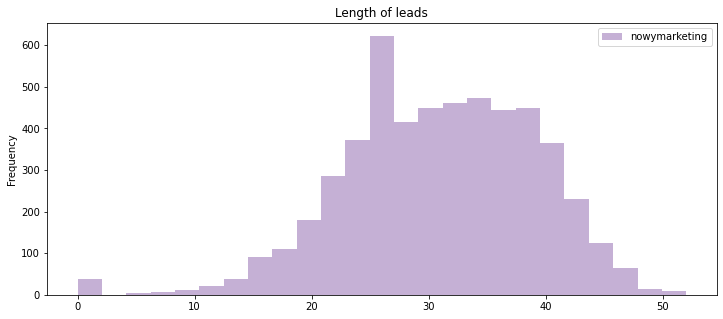

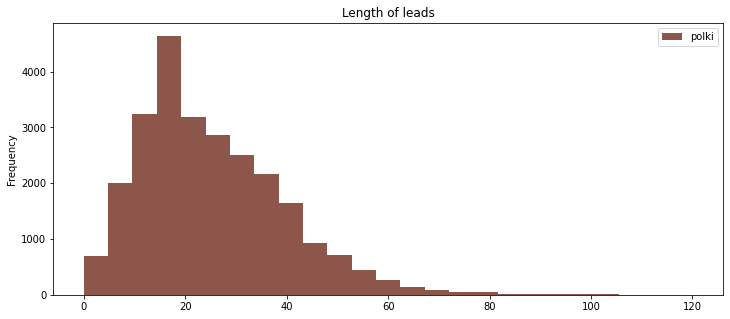

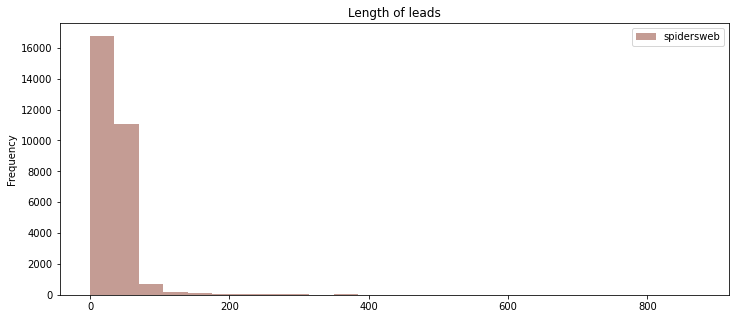

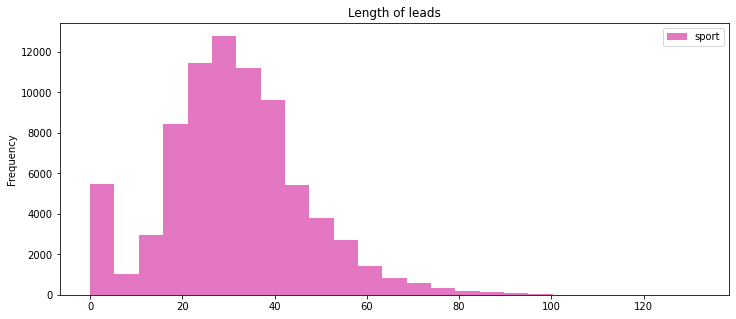

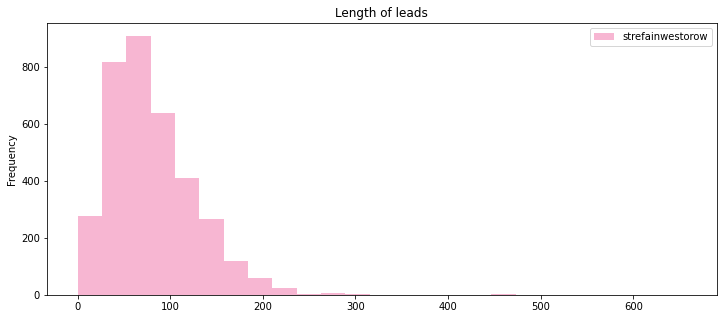

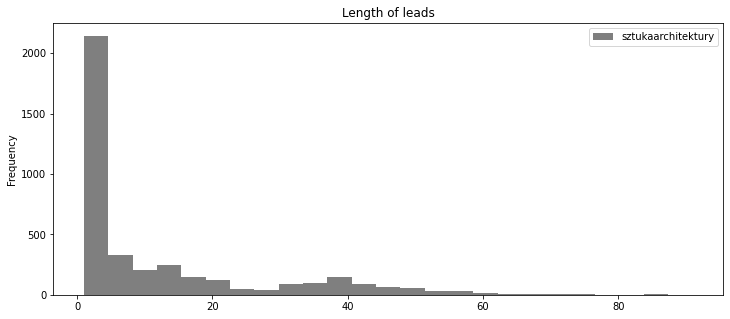

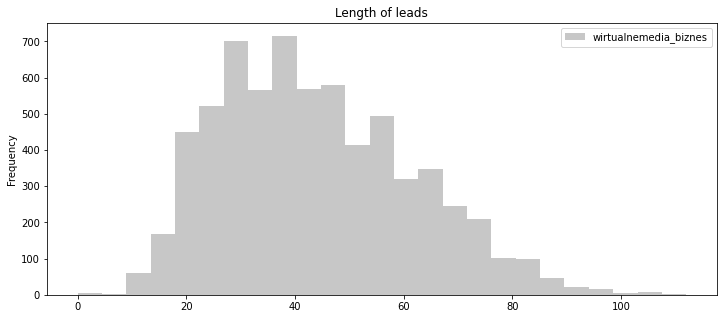

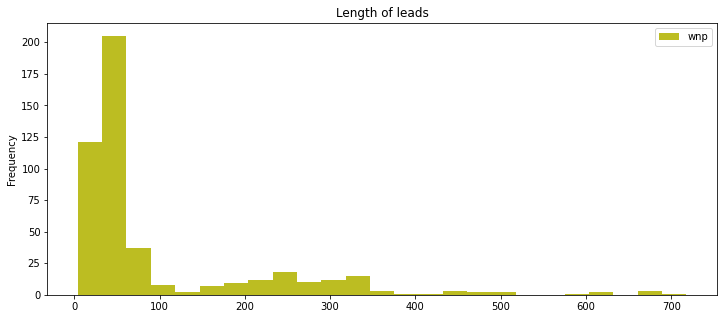

In [197]:
plot_data_for_column_single(file_reader.data, file_reader.file_names, column='lead', max_percentile=1)

# Filter data

In [202]:
filterer = Filterer(title_lead_length_limit=(10, 200), text_length_limit=(40, 2000))

In [203]:
test_filtered = filterer.filter_site_data(file_reader.data['gazetakrakowska'])
test_filtered.head()

,url,title,lead,text
0,https://gazetakrakowska.pl/jordanow-w-nocy-spl...,[Jordanów. W nocy spłonął tartak. Niemal 70 st...,[Nocny pożar w Jordanowie w powiecie suskim. W...,[Ogień został zauważony o godz. 3.30 w nocy. N...
1,https://gazetakrakowska.pl/koronawirus-w-nowym...,[Koronawirus w Nowym Sączu. Wracający z zagran...,"[Sądeczanie, którzy wracają do domu z zagranic...",[Wielu Sądeczan pracujących zagranicą w związk...
2,https://gazetakrakowska.pl/krakow-trwa-budowa-...,[Kraków. Trwa budowa wodnego placu zabaw w par...,[Postępują prace związane z budową wodnego pla...,"[Wodny , plac zabaw, w parku Jordana to jedno..."
3,https://gazetakrakowska.pl/koronawirus-tarnow-...,[Koronawirus Tarnów. Wracający z zagranicy nie...,"[Mieszkańcy Tarnowa i regionu, którzy planują ...",[Pani Katarzyna spod Tarnowa pracowała dotąd w...
4,https://gazetakrakowska.pl/koronawirus-francis...,[Koronawirus. Franciszkanie z Krakowa zachęcaj...,"[W trakcie walki z epidemią koronawirusa, w Po...","[Powstają różne inicjatywy, jak wspierać tych,..."


### Max

In [204]:
test_filtered.applymap(lambda x: len(" ".join(x).strip().split()) if isinstance(x, list) else len(x.strip().split())).max()

url         1
title      26
lead      172
text     1887
dtype: int64

### Min

In [205]:
test_filtered.applymap(lambda x: len(" ".join(x).strip().split()) if isinstance(x, list) else len(x.strip().split())).min()

url       1
title     0
lead     10
text     40
dtype: int64

In [206]:
data_filtered = {}

In [207]:
for site in file_reader.file_names:
    data_filtered[site] = filterer.filter_site_data(file_reader.data[site])

In [208]:
from IPython.display import display

In [209]:
for site in file_reader.file_names:
    display(site, len(data_filtered[site]), data_filtered[site].head())

'bankier'

0

""


'bankier_moto'

650

,url,title,lead,text
0,https://www.bankier.pl/moto/koronawirus-przysp...,[Koronawirus przyspieszy sprzedaż samochodów o...,[Epidemia koronawirusa przyspieszy rozwój sprz...,"[Według Balcerzyka, choć sprzedaż bezpośrednia..."
1,https://www.bankier.pl/moto/auta-w-polsce-truj...,[Auta w Polsce trują najmocniej w Europie],[Samochody zarejestrowane w Polsce emitowały w...,[Samochody zarejestrowane w Polsce emitowały w...
2,https://www.bankier.pl/moto/przebieg-auta-pod-...,[Przebieg auta pod większą kontrolą],[Kontrolowanie stanu liczników ma być antidotu...,"[Jak podaje gazeta, od 15 marca w życie wchodz..."
3,https://www.bankier.pl/moto/darmowe-parkingi-w...,[Darmowe parkingi w Krakowie do końca marca],[Od niedzieli do końca marca nie będzie poboru...,"[„Chcemy ułatwić funkcjonowanie tym osobom, kt..."
4,https://www.bankier.pl/moto/fabryka-opla-w-gli...,[Fabryka Opla w Gliwicach zawiesza produkcję; ...,"[Od wtorku gliwicka fabryka samochodów Opla, n...","[Od wtorku gliwicka fabryka samochodów Opla, n..."


'bankier_previous'

3142

,url,title,lead,text,text_main_points
0,https://www.bankier.pl/wiadomosc/Oszustwo-SMS-...,"[""Pieniądze z Państwa konta przekazane do NBP""...",[Największy bank w Polsce bije na alarm: oszuś...,"[""Przekażcie dalej i ostrzeżcie znajomych"" - a...",[]
1,https://www.bankier.pl/wiadomosc/Zakaz-handlu-...,[Zakaz handlu zawieszony z powodu koronawirusa...,[Zawieszenie wejścia w życie wszelkich ustaw w...,[\r\nJak czytamy w stanowisku KIG przysłanym w...,[]
2,https://www.bankier.pl/wiadomosc/Czechy-zamyka...,[Czechy zamykają sklepy i restauracje],[Władze Republiki Czeskiej poinformowały w noc...,[Otwarte będą natomiast wszystkie stacje benzy...,[]
3,https://www.bankier.pl/wiadomosc/5-tematow-min...,[5 tematów mijającego tygodnia ważnych dla two...,[W mijającym tygodniu\r\nopisywaliśmy szereg t...,[W ramach cyklu „5\r\ntematów minionego tygodn...,[]
4,https://www.bankier.pl/wiadomosc/Turczynowicz-...,[Turczynowicz-Kieryłło rezygnuje funkcji szefo...,[Z uwagi na stan zdrowia nie będę pełnić już f...,"[\r\n, ""Moi Drodzy, z uwagi na stan zdrowia ni...",[]


'bryla'

3506

,url,title,lead,text
0,"http://www.bryla.pl/bryla/1,85298,12455850,Wer...","[Wertykalna fawela, czyli Wieża Davida w Carac...",[Niedokończony wieżowiec w Caracas został spon...,"[Pamiętacie historię , opuszczonego wieżowca S..."
1,"http://www.bryla.pl/bryla/7,85301,24940681,wil...",[Willa w Kościelisku - nowoczesny dom z szacun...,"[Ten dom jednorodzinny w Kościelisku, autorstw...",[Willa Frame w Kościelisku to najnowszy projek...
2,http://www.bryla.pl/vittorio-gregotti-nie-zyje...,"[Vittorio Gregotti nie żyje. Włoski architekt,...",[Vittorio Gregotti zmarł 15 marca w Mediolanie...,[Vittorio Gregotti urodził się w 1927 roku w N...
3,http://www.bryla.pl/tak-bedzie-wygladal-tzw-pl...,[Tak będzie wyglądał tzw. plac trójkątny na Pr...,[Lustrzane zadaszenie i park kieszonkowy. Mar...,[Kilka dni temu ogłoszono wyniki konkursu urba...
4,http://www.bryla.pl/li-edelkoort-koronawirus-s...,[Li Edelkoort: koronawirus spowoduje kwarantan...,[Jaki wpływ będzie miała epidemia koronowirusa...,[Lidewij Edelkoort zajmuje się przewidywaniem ...


'gazetakrakowska'

9570

,url,title,lead,text
0,https://gazetakrakowska.pl/jordanow-w-nocy-spl...,[Jordanów. W nocy spłonął tartak. Niemal 70 st...,[Nocny pożar w Jordanowie w powiecie suskim. W...,[Ogień został zauważony o godz. 3.30 w nocy. N...
1,https://gazetakrakowska.pl/koronawirus-w-nowym...,[Koronawirus w Nowym Sączu. Wracający z zagran...,"[Sądeczanie, którzy wracają do domu z zagranic...",[Wielu Sądeczan pracujących zagranicą w związk...
2,https://gazetakrakowska.pl/krakow-trwa-budowa-...,[Kraków. Trwa budowa wodnego placu zabaw w par...,[Postępują prace związane z budową wodnego pla...,"[Wodny , plac zabaw, w parku Jordana to jedno..."
3,https://gazetakrakowska.pl/koronawirus-tarnow-...,[Koronawirus Tarnów. Wracający z zagranicy nie...,"[Mieszkańcy Tarnowa i regionu, którzy planują ...",[Pani Katarzyna spod Tarnowa pracowała dotąd w...
4,https://gazetakrakowska.pl/koronawirus-francis...,[Koronawirus. Franciszkanie z Krakowa zachęcaj...,"[W trakcie walki z epidemią koronawirusa, w Po...","[Powstają różne inicjatywy, jak wspierać tych,..."


'krakowwpigulce'

3956

,url,title,lead,text
0,https://krakowwpigulce.pl/2020/03/18/koronawir...,[Koronawirus w Polsce: 8 lat więzienia za prze...,"[Ministerstwo Zdrowia ostrzegało, że osoby prz...","[W większości kwarantanna jest utrzymywana, al..."
1,https://krakowwpigulce.pl/2020/03/18/zwolnil-w...,[Zwolnił Wam internet? To przez… koronawirusa],[Pandemia koronawirusa ma wpływ na wszystkie a...,"[SpeedTest.pl, serwis do testowania prędkości ..."
2,https://krakowwpigulce.pl/2020/03/17/koronawir...,[Koronawirus: osoby z tą grupą krwi zarażają s...,[Zespół Chińskich naukowców kierowanych przez ...,"[Badacze sprawdzili grupę krwi ponad 2 tys, pa..."
3,https://krakowwpigulce.pl/2020/03/18/platnosci...,[Płatności bez kodu PIN do 100 złotych już w t...,[Mastercard już w ten weekend podniesie limit ...,[Formalnie nowe regulacje wejdą w życie w nocy...
4,https://krakowwpigulce.pl/2020/03/18/lekarka-o...,[Lekarka objęta kwarantanną przyjmowała pacjen...,"[Sprawa z woj. Śląskiego, niemniej bulwersując...",[Jako pierwszy sprawę opisał lokalny portal no...


'mamstartup'

91

,url,title,lead,text,text_list
0,https://mamstartup.pl/jak-w-zwiazku-z-koronawi...,[Jak w związku z koronawirusem wdrożyliśmy pra...,[\n Czasami musisz ...,[Do tej pory w 40-osobowym zespole TimeCamp ty...,[]
1,https://mamstartup.pl/jak-zwiekszyc-sprzedaz-d...,"[Jak zwiększyć sprzedaż dzięki TikTok?, {{ pos...",[\n Co trzeciemu uż...,[Pierwsze wydanie aplikacji TikTok (pod nazwą ...,[]
2,https://mamstartup.pl/ggpredict-zwyciezca-konk...,[GGPredict zwycięzcą konkursu ł.pitch Start-up...,[\n GGPredict zosta...,[GGPredict to twórca aplikacji zwiększającej o...,[]
3,https://mamstartup.pl/polski-sensdx-pracuje-na...,[Polski SensDx pracuje nad testem do wykrywani...,[\n Działający w Gd...,[Już udało się wyselekcjonować białka charakte...,[]
4,https://mamstartup.pl/zen-i-mastercard-przygot...,[ZEN i Mastercard przygotowują się do wprowadz...,"[\n ZEN, pierwszy p...",[Aktualnie ZEN opracowuje strategię marketingo...,[]


'naszemiasto'

254

,url,title,lead,text
0,https://poznan.naszemiasto.pl/koronawirus-w-po...,[Koronawirus w Poznaniu: 15. osoba zakażona w ...,[U kolejnej osoby w Wielkopolsce potwierdzono ...,"[Zobacz też: , Poznaniacy urządzają pikniki na..."
1,https://lodz.naszemiasto.pl/bezplatne-e-booki-...,[Bezpłatne e-booki dla czytelników Biblioteki ...,[Biblioteka Miejska w Łodzi uruchomiła usługę ...,[- Łodzianie mogą bezpłatnie skorzystać z wyku...
2,https://krakow.naszemiasto.pl/tak-pracownicy-p...,[Tak pracownicy pierwszej linii chronią się pr...,[Koronawirus w Polsce odbił się na każdej sfer...,"[Mimo koronawirusa do pracy chodzą: lekarze, p..."
3,https://lodz.naszemiasto.pl/krzysztof-zajas-ch...,"[Krzysztof Zajas: ""Chciałem nadać policyjnej r...","[Z Krzysztofem Zajasem, autorem książki ""Skowy...","[Pochodzi Pan z Oświęcimia, następnie związał ..."
4,https://wroclaw.naszemiasto.pl/grillowanie-we-...,[Grillowanie we Wrocławiu może dużo kosztować....,[Straż miejska będzie karała grillujących w mi...,[- Grillującym grozi 500 zł grzywny – potwierd...


'nowiny24'

51665

,url,title,lead,text
0,https://nowiny24.pl/ministerstwo-zdrowia-poinf...,[Ministerstwo zdrowia poinformowało o kolejnym...,[W piątek po godz. 16 Ministerstwo Zdrowia poi...,[Wśród zakażonych w naszym regionie zmarło dwi...
1,https://nowiny24.pl/plyn-do-podlog-zamiast-sro...,[Płyn do podłóg zamiast środków wirusobójczych...,[Do redakcji Nowin zadzwoniła mieszkanka Rzesz...,"[- Problem jest taki, że w tych trudnych czasa..."
2,https://nowiny24.pl/19letni-kierowca-bmw-uciek...,[19-letni kierowca BMW uciekał przed policją w...,"[Policjanci prowadzili pościg za kierowcą BMW,...",[Funkcjonariusze rzeszowskiego oddziału prewen...
3,https://nowiny24.pl/w-mielcu-pijany-60latek-gr...,[W Mielcu pijany 60-latek groził ekspedientkom...,[Pijany 60-latek chciał kupić alkohol w sklepi...,"[W środę przed godz. 19, do sklepu przy al. Du..."
4,https://nowiny24.pl/jacht-rzeszowiak-plynie-w-...,[Jacht „Rzeszowiak” płynie w tym roku na Horn ...,"[Decyzja zapadła – w tym roku jacht ""Rzeszowia...",[- Taka wyprawa to spore wyzwanie – mów kapita...


'nowymarketing'

2381

,url,title,lead,text
0,"https://nowymarketing.pl/a/25483,koronamarketi...","[Koronamarketing, czyli jak marki radzą sobie ...",[W okresie kwarantanny kluczowym zadaniem mark...,"[<p>Czy przypominacie sobie podobną sytuację, ..."
1,"https://nowymarketing.pl/a/25462,jak-koronawir...",[Jak koronawirus wpływa na branżę reklamową? –...,[Jak pokazuje najnowszy raport MediaCom istotn...,"[<p class=""small""><a href=""https://nowymarketi..."
2,"https://nowymarketing.pl/a/25460,akcja-swiatec...",[Akcja świąteczna #SzaryEkran [case study]],"[6 milionów zaangażowanych odbiorców, najwięks...","[<p>...zmieniając kolor ekranu na szary. </p>,..."
3,"https://nowymarketing.pl/a/25470,the-uncensore...",[The Uncensored Library: W grze Minecraft poja...,[Międzynarodowa organizacja Reporters Without ...,[<p>Z okazji tegorocznego światowego dnia prze...
4,"https://nowymarketing.pl/a/25463,volvo-stworzy...","[Volvo stworzyło billboard, który oczyszcza po...",[Portugalski oddział Volvo zainstalował w Port...,[<p>Codziennie spotykamy na ulicach setki bill...


'polki'

14611

,url,title,lead,text
0,"https://polki.pl/zdrowie/choroby,ibuprofen-vs-...",[Ibuprofen vs paracetamol – dlaczego jednego z...,"[Nie bierz ibuprofenu, gdy podejrzewasz u sieb...","[\n, Spis treści:, \n, Światowa Organizacja Zd..."
1,"https://polki.pl/zdrowie/choroby,koronawirus-c...",[Co dziś wiemy o pracach nad szczepionką na ko...,[Naukowcy z Kanady wyizolowali wirusa SARS-CoV...,"[\n, Koronawirus dotarł do ponad 60 krajów i z..."
2,"https://polki.pl/zdrowie/choroby,szczepionka-j...",[Szczepionka na koronawirusa - jak jest testow...,[Pandemia koronawirusa wymusza na naukowcach p...,[<h2>\nJak wygląda praca nad szczepionkami?</h...
3,"https://polki.pl/zdrowie/choroby,20-waznych-py...",[20 ważnych pytań o koronawirusa. Te rzeczy tr...,[Czy można zachorować dwa razy? Jakie leki są ...,[\nOsób zarażonych koronawirusem jest w Polsce...
4,"https://polki.pl/zdrowie/choroby,jak-chronic-o...",[Jak chronić osoby starsze przed koronawirusem...,"[Immunolodzy ostrzegają, że wirus SARS-CoV-2 j...",[\nEksperci nadal nie znają odpowiedzi na wiel...


'spidersweb'

27214

,url,title,lead,text
0,https://www.spidersweb.pl/2020/03/koronawirus-...,"<h1 class=""white"">Wielka Brytania i Szwecja le...",[Epidemia spowodowana koronawirusem potrwa w W...,[<p><strong>Epidemia spowodowana koronawirusem...
1,https://spidersweb.pl/bizblog/gotowka-podatek-...,"<h1 class=""b-post__title"">\nKoronawirus do spó...",[Polacy już dawno zapomnieli o wywieszkach w s...,[<p><strong>Polacy już dawno zapomnieli o wywi...
2,https://www.spidersweb.pl/2020/03/koronawirus-...,"<h1 class=""white"">Idzie kryzys tak ogromny, ja...","[Nie pamiętam. Nie pamiętam takich czasów, mim...",[<p><strong>Nie pamiętam. Nie pamiętam takich ...
3,https://www.spidersweb.pl/2020/03/koronawirus-...,"<h1 class=""white"">#HomeOffice: Koronawirus zam...",[Pandemia koronawirusa to dla wielu koniecznoś...,[<p><strong>Pandemia koronawirusa to dla wielu...
4,https://www.spidersweb.pl/2020/03/platnosci-be...,"<h1 class=""white"">Sprzedawca wprowadza PIN za ...",[Brudna mamona jest siedliskiem bakterii i wir...,[<p><strong>Brudna mamona jest siedliskiem bak...


'sport'

71101

,url,title,lead,text
0,"https://www.sport.pl/pilka/7,64946,25802268,to...",[\n \n Tomasz Hajto pożyczył 200 tys...,"[Jak udało nam się ustalić, Rafał Kosiec pożyc...",[Ponad 200 tysięcy złotych - tyle według naszy...
1,"https://www.sport.pl/pilka/7,65041,25727002,cu...","[\n \n Słowa tabu w Bayernie. ""Skoro...",[We wtorek Chelsea zagra z Bayernem Monachium ...,"[Zaraz po tym, jak , Bayern Monachium, wyloso..."
2,"https://www.sport.pl/pilka/7,65041,25731646,le...",[\n \n Lewandowski wskazywał bohater...,[Najpierw Robert Lewandowski nie wykorzystał d...,"[Od początku było widać, że dla Lewandowskiego..."
3,"https://www.sport.pl/pilka/7,65041,25732068,fe...","[\n \n Fenomen, piłkarska wersja Bol...","[Jak na najlepszy wynalazek przystało, Alphons...","[Wtorkowy mecz był dla , Alphonso Davisa, wyj..."
4,"https://www.sport.pl/pilka/7,65041,25731783,le...","[\n \n ""Lewandowski jest bliżej Złot...",[Robert Lewandowski był kluczowym piłkarzem me...,[Bayern Monachium pokonał na wyjeździe Chelsea...


'strefainwestorow'

3171

,url,title,lead,text
0,https://strefainwestorow.pl/artykuly/gielda-us...,[Apple zamyka wszystkie sklepy poza Chinami ab...,"[Apple poinformowało, że zamyka wszystkie swoj...","[Apple poinformowało, że zamyka wszystkie swoj..."
1,https://strefainwestorow.pl/artykuly/ludzie/20...,[Czy kobiety interesują się rynkiem kapitałowy...,[Na rynku kapitałowym dominuje płeć męska. A i...,[Na rynku kapitałowym dominuje płeć męska. A i...
2,https://strefainwestorow.pl/artykuly/fundusze-...,[Wyniki funduszy inwestycyjnych quant w USA ro...,[Fundusze oparte na zautomatyzowanych strategi...,[Fundusze oparte na zautomatyzowanych strategi...
3,https://strefainwestorow.pl/artykuly/dywidendy...,[Wzrost dywidendy z 1 zł do 24 zł w 18 lat - p...,[Grupa Kęty jest jedną z najdłużej notowanych ...,[Grupa Kęty jest jedną z najdłużej notowanych ...
4,https://strefainwestorow.pl/artykuly/prawo/202...,[Rząd mobilizuje siły przeciw koronawirusowi. ...,[Od 8 marca obowiązuje ustawa wprowadzająca sz...,[Od 8 marca obowiązuje ustawa wprowadzająca sz...


'sztukaarchitektury'

1027

,url,title,lead,text
0,https://sztuka-architektury.pl/article/13529/v...,[Vittorio Gregotti ofiarą epidemii],[Vittorio Gregotti urodził się w 1927 roku w p...,"[<p> </p>, <p>Vittorio Gregotti był czynnym ar..."
1,https://sztuka-architektury.pl/article/13434/s...,[Serpentine Pavilion – znamy projekt budynku],[Serpentine Pavilion ma już swoje stałe miejsc...,"[<p> </p>, <p>Początkowo do współpracy przy tw..."
2,https://sztuka-architektury.pl/article/13444/o...,[Organiczny dom jednorodzinny],[Projekt architektoniczny tego domu jednorodzi...,"[<p> </p>, <p> </p>, <p>Organiczna, a zarazem ..."
3,https://sztuka-architektury.pl/article/13460/n...,[Niezwykły projekt z drewna – kaplica w lesie],[Portal Archdaily.com ogłosił wyniki plebiscyt...,"[<p> </p>, <p>Wśród obiektów sakralnych najlep..."
4,https://sztuka-architektury.pl/article/13462/z...,[Zobacz najciekawsze fotografie architektury],[World Photography Organisation ogłosiła nazwi...,"[<p> </p>, <p>Architektura w fotografii</p>, <..."


'wirtualnemedia_biznes'

6598

,url,title,lead,text
0,https://www.wirtualnemedia.pl/artykul/dominika...,[Dominika Kulczyk przekaże 20 mln zł na walkę ...,[Dominika Kulczyk zdecydowała się przekazać Fu...,[Środki zostaną przekazane na zakup: sprzętu d...
1,https://www.wirtualnemedia.pl/artykul/koronawi...,[Maspex przekaże szpitalom zakaźnym 1 mln swoi...,"[Firma spożywcza Maspex, do której należą m.in...","[Maspex wyliczył, że przekaże szpitalom zakaźn..."
2,https://www.wirtualnemedia.pl/artykul/colian-p...,[Colian przekaże słodycze i napoje szpitalom p...,[Spółka Colian (właściciel takich marek jak He...,"[Spółka , Colian , zadeklarowała wysyłkę słody..."
3,https://www.wirtualnemedia.pl/artykul/biznes24...,[Marcin Dobrowolski twarzą Biznes24. Start kan...,[Głównym prowadzącym w nowej stacji Biznes24 -...,"[Biznes24 to kanał poświęcony biznesowi, gospo..."
4,https://www.wirtualnemedia.pl/artykul/zus-wpro...,[ZUS wprowadza ułatwienia dla firm. Konfederac...,[Nie czekając na decyzje rządu w sprawie pakie...,"[Zakład Ubezpieczeń Społecznych poinformował, ..."


'wnp'

200

,url,title,lead,text,text_main_points
0,https://www.wnp.pl/energetyka/pge-wobec-korona...,[PGE wobec koronawirusa. Gwarantuje dostawy pr...,[Polska Grupa Energetyczna (PGE) 13 marca zape...,"[\n , \n\n , \n\n\t\n\t\n Spółka odpo...",[]
1,https://www.wnp.pl/chemia/policzyli-ile-ciech-...,"[Policzyli, ile Ciech dał całemu województwu]",[EY opublikował ekspercki raport na temat wpły...,"[\n , \n\n , \n\n\t\n\t\n , \r\n, Obl...",[W ocenie prezesa firmy Dawida Jakubowicza Gru...
2,https://www.wnp.pl/przemysl-obronny/koronawiru...,[Koronawirus dopadł polską armię],"[Żarty się skończyły, zaczęły się schody. W Po...","[\n , \n\n , \n\n\t\n\t\n , \nTo było...","[Koronawirus dopadł polską armię, gen. Jarosła..."
3,https://www.wnp.pl/hutnictwo/arcelormittal-wzy...,[ArcelorMittal wzywa rządy UE do poparcia węgl...,"[ArcelorMittal wezwał państwa członkowskie, by...","[\n , \n\n , \n\n\t\n\t\n Według Arce...",[]
4,https://www.wnp.pl/hutnictwo/cla-trumpa-zamyka...,[Cła Trumpa zamykają amerykańską walcownię],[Walcownia NLMK Pensylwania musi kupować stal ...,"[\n , \n\n , \n\n\t\n\t\n Walcownia N...",[]


In [210]:
sum([len(data_filtered[site]) for site in file_reader.file_names])

199137

# Merge data

In [213]:
dataframes = []
for site in file_reader.file_names:
    data = data_filtered[site]
    data['site'] = site
    dataframes.append(data)

data_all = pd.concat(dataframes, ignore_index=True)

In [214]:
data_all

,site,url,title,lead,text,text_main_points,text_list
0,bankier_moto,https://www.bankier.pl/moto/koronawirus-przysp...,[Koronawirus przyspieszy sprzedaż samochodów o...,[Epidemia koronawirusa przyspieszy rozwój sprz...,"[Według Balcerzyka, choć sprzedaż bezpośrednia...",NaN,NaN
1,bankier_moto,https://www.bankier.pl/moto/auta-w-polsce-truj...,[Auta w Polsce trują najmocniej w Europie],[Samochody zarejestrowane w Polsce emitowały w...,[Samochody zarejestrowane w Polsce emitowały w...,NaN,NaN
2,bankier_moto,https://www.bankier.pl/moto/przebieg-auta-pod-...,[Przebieg auta pod większą kontrolą],[Kontrolowanie stanu liczników ma być antidotu...,"[Jak podaje gazeta, od 15 marca w życie wchodz...",NaN,NaN
3,bankier_moto,https://www.bankier.pl/moto/darmowe-parkingi-w...,[Darmowe parkingi w Krakowie do końca marca],[Od niedzieli do końca marca nie będzie poboru...,"[„Chcemy ułatwić funkcjonowanie tym osobom, kt...",NaN,NaN
4,bankier_moto,https://www.bankier.pl/moto/fabryka-opla-w-gli...,[Fabryka Opla w Gliwicach zawiesza produkcję; ...,"[Od wtorku gliwicka fabryka samochodów Opla, n...","[Od wtorku gliwicka fabryka samochodów Opla, n...",NaN,NaN
...,...,...,...,...,...,...,...
199132,wnp,https://www.wnp.pl/nafta/lotos-przekaze-5-mln-...,[Lotos przekaże 5 mln zł na walkę z koronawiru...,[Grupa Lotos za pośrednictwem Fundacji Lotos z...,"[\n , \n\n , \n\n\t\n\t\n Wsparcie re...",[],NaN
199133,wnp,https://www.wnp.pl/gazownictwo/gazprom-ma-wiel...,[Gazprom ma wielki problem. Gaz się przestał s...,[Tylko 19 mln m3 gazu sprzedał podczas ostatni...,"[\n , \n\n , \n\n\t\n\t\n Elektronicz...",[],NaN
199134,wnp,https://www.wnp.pl/budownictwo/dane-planistycz...,[Dane planistyczne będą powszechnie dostępne],[Jak poinformowało 13 marca Ministerstwo Rozwo...,"[\n , \n\n , \n\n\t\n\t\n , \n\n, \n-...",[W komunikacie na okolicznośc dalszych prac le...,NaN
199135,wnp,https://www.wnp.pl/energetyka/cieplownictwo/se...,[Sefako ma pełny portfel zamówień],[Portfel zamówień na 2020 r. mamy już praktycz...,"[\n , \n\n , \n\n\t\n\t\n , \nPrzypom...",[Aktualnie kluczowym zleceniem Sefako jest war...,NaN


In [215]:
data_all.to_csv('../data/polish_articles.csv')